# Visualizing gradients: VPG and NPG
The functionalities in this notebook can be used to plot the vanilla policy gradient and natural policy gradient for the examples in exercise 7.3 and 8.1 respectively. 

In [1]:
# Imports
import torch
from matplotlib import pyplot as plt
from matplotlib import patches

In [2]:
# Constants
MU_MAX = 1.25
MU_MIN = -0.25
SIGMA_MIN = 0.0001
SIGMA_MAX = 1
PLOT_Y_EXCESS = 0.025
PLOT_X_EXCESS = 0.05

ARROW_WIDTH = 0.007
ARROW_SCALE = 20
ARROWS_PER_DIM = 11

CONTOUR_POINTS = 50
CONTOUR_LEVELS = 100

K_VALUES = [0.1, 1, 10]

## Info
This code will allow you to generate nice plots that you can use to compare VPG and NPG. Inspect the code (you do not have to understand every detail). You will need to implement two methods which calculate gradients. These are used in *plot_normalized_grads* function. Additionally, you need to implement *expected_reward* function which is used in *plot_contour*.

In [3]:
def plot_contour(ax, k):
    """
    Plots contour the color of which corresponds to expected reward
    :param ax: Ax used for plotting
    :param k: Hyperparameter k
    """
    
    # Create meshgrids for plotting 
    mu_grid, sigma_grid = torch.meshgrid(torch.linspace(MU_MIN - PLOT_X_EXCESS,
                                                        MU_MAX + PLOT_X_EXCESS,
                                                        CONTOUR_POINTS),
                                         torch.linspace(SIGMA_MIN - PLOT_Y_EXCESS, 
                                                        SIGMA_MAX + PLOT_Y_EXCESS,
                                                        CONTOUR_POINTS))
    
    # Transform from distribution parameters to theta parameters
    theta_mu = mu_grid
    theta_sigma = sigma_grid / k
    
    # Get expected rewards for all parameter combinations
    r = expected_reward(theta_mu, theta_sigma, k)
    ax.contourf(mu_grid, sigma_grid, r, levels=torch.linspace(torch.min(r),torch.max(r), CONTOUR_LEVELS))

In [4]:
def plot_normalized_grads(ax, grad_function, k):
    """
    Plot the direction of gradients (gradients are normalized to unit length)
    :param ax: ax used for plotting
    :param grad_function: a function that is used to calculate the gradient
    :param k: hyperparameter k
    """
    # Create meshgrids to get all combinations of params
    mu_grid, sigma_grid = torch.meshgrid(torch.linspace(MU_MIN, MU_MAX, ARROWS_PER_DIM),
                                         torch.linspace(SIGMA_MIN, SIGMA_MAX, ARROWS_PER_DIM))
    
    # Flatten to make grad calculation easier
    mus = mu_grid.contiguous().view(-1,1)
    sigmas = sigma_grid.contiguous().view(-1,1)
    
    # Transform from distribution parameters to theta parameters
    theta_mu = mus
    theta_sigma = sigmas / k
    
    # Calculate gradients
    g = grad_function(mu_params=theta_mu, sigma_params=theta_sigma, k=k)
    
    # Transform change wrt. theta_sigma to sigma dimension
    g[:, 1] = g[:, 1] * k
    
    # Normalize gradient
    g = g / g.norm(dim=1, keepdim=True)
    ax.quiver(mus, sigmas, g[:, 0], g[:, 1], scale=ARROW_SCALE, width=ARROW_WIDTH)

In [5]:
def create_plot(fig, plot_npg=False):
    """
    Creates plot with VPG (and optionally NPG) gradients
    :param fig: figure used for plotting
    :param plot_npg: if set to true also adds NPG gradients to the plot
    """
    n_k_values = len(K_VALUES)
    
    for i in range(1 + plot_npg):
        for j in range(n_k_values):
            ax = fig.add_subplot(1 + plot_npg, n_k_values, i * n_k_values + j + 1)
            
            # Set up ax and grad function
            if i == 0:
                ax.set_title("Vanilla policy grad k={}".format(K_VALUES[j]))
                grad_function = vanilla_grad
            else:
                ax.set_title("Natural policy grad k={}".format(K_VALUES[j]))
                grad_function = natural_grad
            ax.set_xlabel("Mu")
            ax.set_ylabel("Sigma")
            ax.set_aspect(1)
            ax.set_ylim(SIGMA_MIN-PLOT_Y_EXCESS, SIGMA_MAX + PLOT_Y_EXCESS)
            ax.set_xlim(MU_MIN - PLOT_X_EXCESS, MU_MAX + PLOT_X_EXCESS)
            
            plot_contour(ax=ax, k=K_VALUES[j])
            plot_normalized_grads(ax=ax, grad_function=grad_function, k=K_VALUES[j])

## Implementation
Use results from the exercise and implement functions that calculate both gradient as well as expected reward.

In [11]:
# IMPLEMENTED BY STUDENT
def vanilla_grad(mu_params, sigma_params, k):
    """
    Calculates VPG using parameters mu and sigma and hyperparameter k 
    :param mu_params: tensor (Mx1) with mu parameters
    :param sigma_params: tensor (Mx1) with sigma parameters
    :param k: Hyperparameter k
    :returns: tensor (Mx2) with gradients wrt. mu and sigma
    """
    # Note: You need to implemented this for the example in exercise 7.3.
    # YOUR CODE HERE 
    return torch.cat((1 - 2*mu_params, -2*k**2*sigma_params), 1)
    
def natural_grad(mu_params, sigma_params, k):
    """
    Calculates NPG using parameters mu and sigma and hyperparameter k 
    :param mu_params: tensor (Mx1) with mu parameters
    :param sigma_params: tensor (Mx1) with sigma parameters
    :param k: Hyperparameter k
    :returns: tensor (Mx2) with gradients wrt. mu and sigma
    """
    # Note: You need to implemented this for the example in exercise 8.1.
    # YOUR CODE HERE
    return torch.cat((k**2*sigma_params**2*(1 - 2*mu_params), -k**2*sigma_params**3), 1)

def expected_reward(mu_params, sigma_params, k):
    """
    Calculates exewcted reward using parameters mu and sigma and hyperparameter k 
    :param mu_params: tensor (Mx1) with mu parameters
    :param sigma_params: tensor (Mx1) with sigma parameters
    :param k: Hyperparameter k
    :returns: tensor (Mx1) with expected rewards
    """
    # YOUR CODE HERE
    return mu_params - mu_params**2 - k**2*sigma_params**2

## Create plots

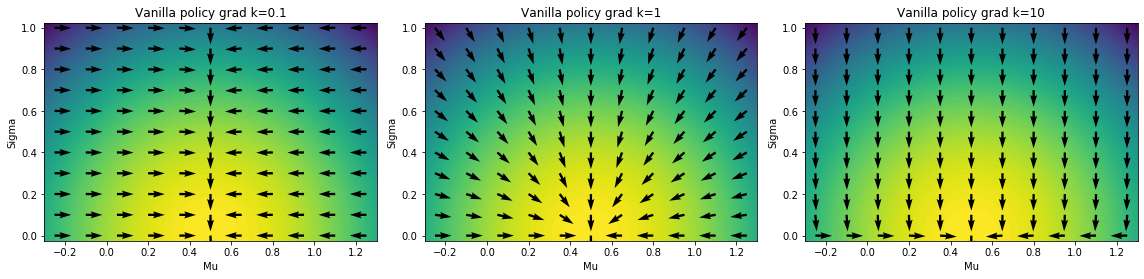

In [9]:
# Create VPG plot
fig = plt.figure(figsize=(16, 9))
create_plot(fig, plot_npg=False)
fig.tight_layout()
fig.savefig("vpg_plot.pdf", dpi=400, bbox_inches='tight')

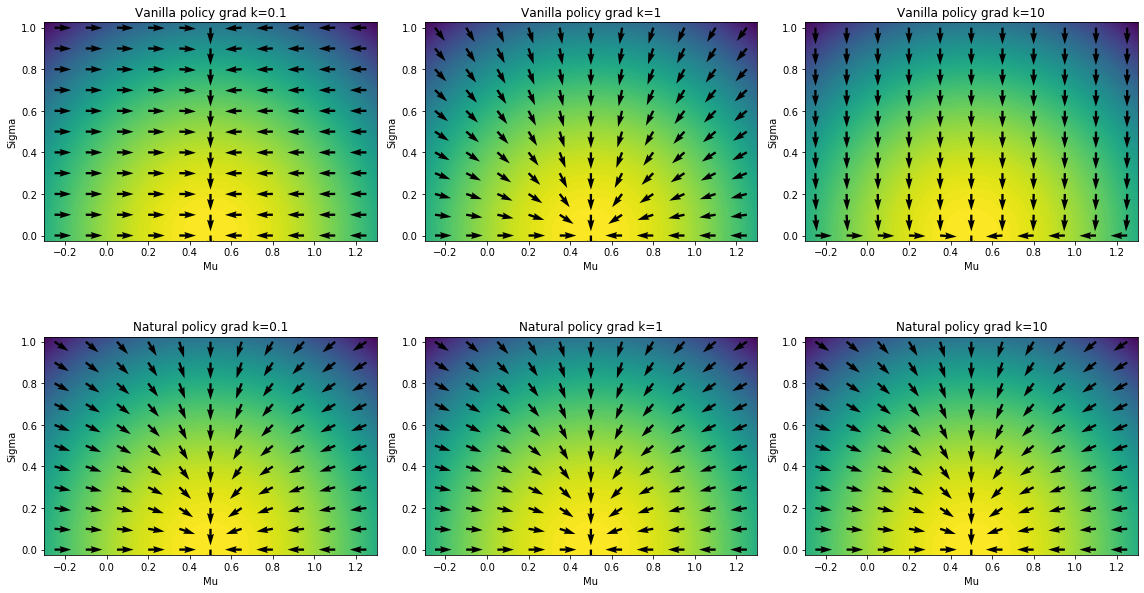

In [12]:
# Create NPG plot
fig = plt.figure(figsize=(16, 9))
create_plot(fig, plot_npg=True)
fig.tight_layout()
fig.savefig("npg_plot.pdf", dpi=400, bbox_inches='tight')